In [26]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"

import pickle
import random
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
import joblib
import logging
from datetime import datetime
from argparse import ArgumentParser
import src.utils as utils
from src.utils import normalize_answer, find_subsequence, exact_match_score
import json
import matplotlib.pyplot as plt

In [17]:
#data = utils.load_parquet_data('results/llama-2-7b-hf/HotpotQA-2000-0.2per-seed0-modify.jsonl')
data = utils.load_parquet_data('results/llama-2-7b-hf/HotpotQA-2000-2per-seed0-modify.jsonl')

# evaluate Greedy
print('------------------Greedy------------------')
greedy_em, _, _ = utils.evaluate_em(data, 'gold_ans', 'greedy_ans')
greedy_f1, _, _ = utils.evaluate_f1(data, 'gold_ans', 'greedy_ans')

print(f"EM: {greedy_em * 100}")
print(f"F1: {greedy_f1 * 100}\n")

# evaluate RAG Hallu
print('------------------RAG Hallu------------------')
ours_em, _, _ = utils.evaluate_em(data, 'gold_ans', 'pred_ans')
ours_f1, _, _ = utils.evaluate_f1(data, 'gold_ans', 'pred_ans')


print(f"EM: {ours_em * 100}")
print(f"F1: {ours_f1 * 100}\n")

------------------Greedy------------------
EM: 43.22
F1: 53.61

------------------RAG Hallu------------------
EM: 43.22
F1: 53.61



In [24]:
correct = []
incorrect = []
correct_marginalized_prob = []
incorrect_marginallized_prob = []

for i, item in enumerate(data):

    if exact_match_score(item['gold_ans'][0], item['pred_ans']):
        correct.append(item)
        correct_marginalized_prob.append(item['after_prob'])
    else:
        incorrect.append(item)
        incorrect_marginallized_prob.append(item['after_prob'])
        
print(f"Total correct: {100 * len(correct) / len(data): .2f}%")
print(f"Correct marginalized prob: {np.mean(correct_marginalized_prob): .4f}")
print(f"Incorrect marginalized prob: {np.mean(incorrect_marginallized_prob): .4f}")

Total correct:  43.22%
Correct marginalized prob:  0.4925
Incorrect marginalized prob:  0.4049


/tmp/ipykernel_37236/2395141572.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_marginalized_prob, incorrect_marginallized_prob], labels=['Correct', 'Incorrect'])


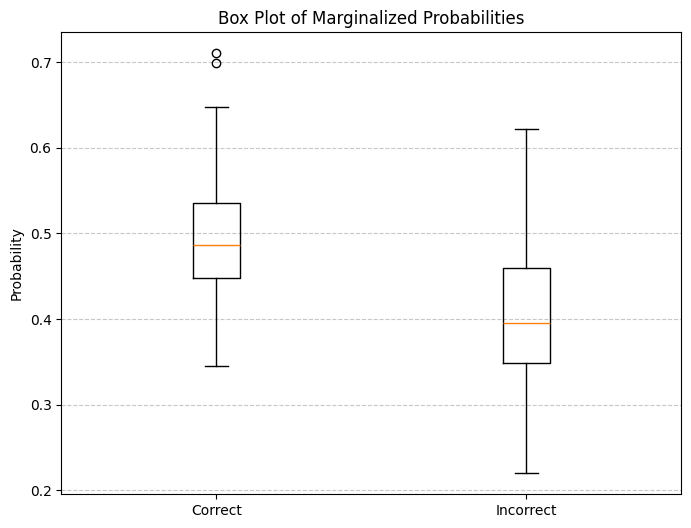

In [27]:
# Box plot for marginalized probabilities
plt.figure(figsize=(8, 6))
plt.boxplot([correct_marginalized_prob, incorrect_marginallized_prob], labels=['Correct', 'Incorrect'])

plt.title('Box Plot of Marginalized Probabilities')
plt.ylabel('Probability')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

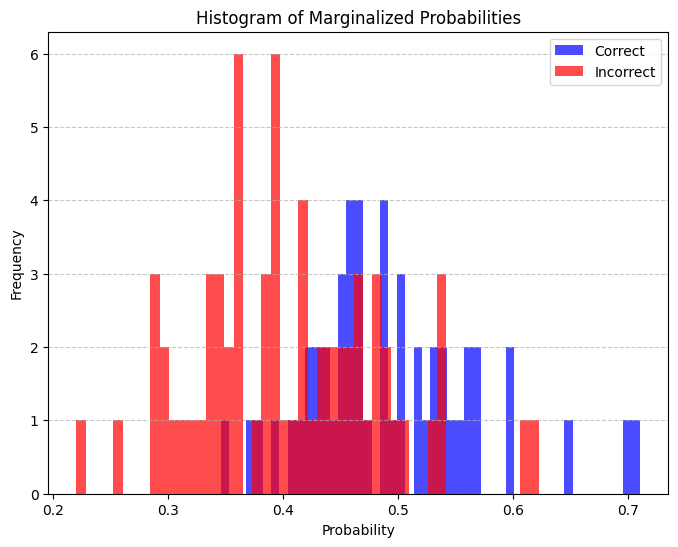

In [30]:
# Histogram for marginalized probabilities
plt.figure(figsize=(8, 6))

# Plot histograms for correct and incorrect marginalized probabilities
plt.hist(correct_marginalized_prob, bins=50, alpha=0.7, color='blue', label='Correct')
plt.hist(incorrect_marginallized_prob, bins=50, alpha=0.7, color='red', label='Incorrect')

plt.title('Histogram of Marginalized Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()